In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from experiment_measurement.rosbag2df import read_rosbag_all_in_one
from experiment_measurement.data_aggregation import aggregate_tables
from driving_swarm_utils.node import DrivingSwarmNode, main_fn
from polygonal_roadmaps import geometry, environment
import geopandas as gpd
from visualization_msgs.msg import MarkerArray, Marker
from geometry_msgs.msg import Point, PoseStamped
from nav_msgs.msg import Path
from std_msgs.msg import ColorRGBA, Int32, Int32MultiArray, String
from std_srvs.srv import Empty
from driving_swarm_messages.srv import SaveToFile, UpdateTrajectory
from sensor_msgs.msg import LaserScan
from trajectory_generator.vehicle_model_node import TrajectoryGenerator, Vehicle
import numpy as np
import rclpy
from shapely import Polygon, simplify, LineString
from shapely import Point as ShapelyPoint
from math import atan2, degrees
import shapely
### change the following line according to what config you want to use
from experiment_measurement.config.trajectory_follower_experiment import table_column_config
import warnings
import yaml

In [34]:
suppress_warnings_list = [
    {
        "category": RuntimeWarning,
        "module": "shapely\.linear",
        "message": "invalid value encountered in shared_paths"
    },
    {
        "category": RuntimeWarning,
        "module": "shapely\.predicates",
        "message": "invalid value encountered in touches"
    },
    {
        "category": UserWarning,
        "module": "geopandas\.plotting",
        "message": "The GeoSeries you are attempting to plot is empty. Nothing has been displayed."
    }
]

# Apply filter for each warning
for warning_detail in suppress_warnings_list:
    warnings.filterwarnings(
        "ignore",
        category=warning_detail["category"],
        module=warning_detail["module"],
        message=warning_detail["message"]
    )


In [35]:
n = 10

with open("/home/yuceel/ItR/tutorials/src/driving_swarm_infrastructure/src/driving_swarm_bringup/params/icra2024_waypoints.yaml", 'r') as file:
    waypoints_data = yaml.safe_load(file)

# Extract start and end positions, but only for the first n waypoints
starts = [item['waypoints'][0][:2] for item in waypoints_data[:n]]
ends = [item['waypoints'][1][:2] for item in waypoints_data[:n]]

In [36]:
def get_db3_files_in_folders(directory):
    db3_files = []
    # Iterate through immediate subdirectories
    for subdir in next(os.walk(directory))[1]:
        subdir_path = os.path.join(directory, subdir)

        # Iterate through files in the subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith(".db3"):
                db3_files.append(os.path.join(subdir_path, filename))

    return db3_files

In [37]:
directory = '/home/yuceel/ItR/tutorials'
db3_files = get_db3_files_in_folders(directory)

In [38]:
db3_files

['/home/yuceel/ItR/tutorials/rosbag_10 robots_2023-09-04_11:06:09/rosbag_10 robots_2023-09-04_11:06:09_0.db3',
 '/home/yuceel/ItR/tutorials/rosbag_9 robots_2023-09-04_11:35:24/rosbag_9 robots_2023-09-04_11:35:24_0.db3']

In [ ]:
# Initialize a counter for the experiment number
experiment_number = 1
dfs = {}
robots = []
# read data from sqlite db
data = read_rosbag_all_in_one(db3_files[0])

# create pandas dataframe from raw data
tables = aggregate_tables(data['rosbag'], table_column_config, 10**9)

# combine data for multiple robots into one dataframe
for robot in tables.keys():
    tables[robot]['robot'] = robot
    robots.append(robot)
    
combined_df = pd.concat(tables.values()).reset_index(drop=True)

initial_timestamp = combined_df['timestamp'].iloc[0]
combined_df['timestamp'] = (combined_df['timestamp'] - initial_timestamp) / 10**9

# Add the experiment number column
combined_df['experiment_number'] = experiment_number

# Store the resulting dataframe in the dfs dictionary
dfs[os.path.basename(db3_file)] = combined_df

# Increment the experiment number for the next iteration
experiment_number += 1

found topics for namespaces: {'turtlebot11', 'turtlebot6', 'turtlebot10', 'turtlebot7', 'turtlebot12', 'turtlebot5', 'turtlebot8', 'turtlebot3', 'turtlebot1', 'turtlebot13'}


In [7]:
class map_loader_without_ros:
    def __init__(self):
        # Simulating parameter declarations and assignments without ROS
        self.parameters = {
        'graph_file': '/home/yuceel/ItR/tutorials/src/driving_swarm_infrastructure/src/driving_swarm_bringup/maps/icra2024.yaml',
        'x_min': -2.25,
        'x_max': 2.75,
        'y_min': -1.75,
        'y_max': 1.25,
        'grid_type': 'square',
        'grid_size': 0.5,
        'inflation_size': 0.1,
        'laser_inflation_size': 0.15,
        'vehicle_model': 3,
        'step_size': 0.1,
        'turn_speed': 0.5,
        'inertia': 0.01,
        'belief_lifetime': 15.0,
        'belief_lifetime_variability': 2.0,
        'horizon': 5,
        'wait_cost': 1.01,
            
        }

        map_file = self.get_parameter('graph_file')
        print(f"map_file value: {map_file}")  # print the value of map_file

        if map_file.endswith(".yaml"):
            grid_size = self.get_parameter('grid_size')
            tiling = self.get_parameter('grid_type')
            print(f"tiling value: {tiling}")  # print the value of tiling
            
            wx = (self.get_parameter('x_min'), self.get_parameter('x_max'))
            wy = (self.get_parameter('y_min'), self.get_parameter('y_max'))

            points = None
            if tiling == 'hex':
                points = geometry.hexagon_tiling(grid_size, working_area_x=wx, working_area_y=wy)
            elif tiling == 'square':
                points = geometry.square_tiling(grid_size, working_area_x=wx, working_area_y=wy)
            elif tiling == 'random':
                points = geometry.random_tiling(50, working_area_x=wx, working_area_y=wy)
            else:
                print('no tiling specified, using hex')
                points = geometry.hexagon_tiling(grid_size, working_area_x=wx, working_area_y=wy)

            assert points is not None

            self.env = environment.RoadmapEnvironment(map_file,
                                                       None,
                                                       None,
                                                       generator_points=points,
                                                       wx=wx,
                                                       wy=wy,
                                                       offset=self.get_parameter('inflation_size'))

        else:
            print("map_file does not end with .yaml")

    def get_parameter(self, key):
        return self.parameters.get(key, None)


In [19]:
def plot_map_with_waypoints(environment, starts, ends, show=False, paths=None):
    plt.figure(figsize=(6.66,4))  # Adjust the size of the figure here
    
    inner = gpd.GeoSeries(n['geometry'].inner for _, n in environment.g.nodes(data=True))
    inner.plot(ax=plt.gca(), alpha=0.1)

    connection = gpd.GeoSeries(e['geometry'].connection for _, _, e in environment.g.edges(data=True))
    connection.plot(ax=plt.gca(),alpha=0.1)

    obstacles = gpd.GeoSeries([environment._obstacles])
    obstacles.plot(ax=plt.gca(), color='gray')
    
    # Generating a list of unique colors for each robot (couple)
    colors = plt.cm.jet(np.linspace(0, 1, len(starts)))

    # for i, ((start_x, start_y), (end_x, end_y)) in enumerate(zip(starts, ends)):
    #     # Plotting start position
    #     start_point = gpd.GeoSeries([geometry.Point(start_x, start_y)])
    #     start_point.plot(ax=plt.gca(), color=colors[i],markersize=100 ,marker='o')
        
    #     # Plotting end position
    #     end_point = gpd.GeoSeries([geometry.Point(end_x, end_y)])
    #     end_point.plot(ax=plt.gca(), color=colors[i],markersize=100, marker='x')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    
    if paths is not None:
        for path in paths:
            path = gpd.GeoSeries([environment.g.nodes()[n]['geometry'].center for n in path if n is not None])
            path.plot(ax=plt.gca(), color='blue')

    if show:
        plt.show()
        plt.close()
    else:
        return plt.gcf(), plt.gca()  # Return the current figure and axis


map_file value: /home/yuceel/ItR/tutorials/src/driving_swarm_infrastructure/src/driving_swarm_bringup/maps/icra2024.yaml
tiling value: square


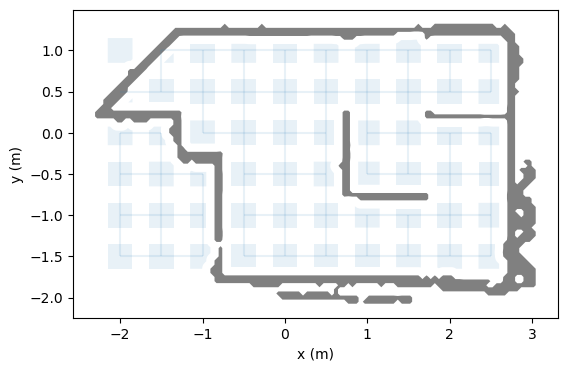

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

map_obj_without_ros = map_loader_without_ros()
map_obj_without_ros.env._start_positions = []
map_obj_without_ros.env._goal_positions = []

fig, ax = plot_map_with_waypoints(map_obj_without_ros.env, starts, ends)  # Here we're capturing the returned figure and axis

# Function to compute distance between points
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to filter data points
def filter_points(df, omit_points, threshold=0.15):
    to_keep = np.ones(len(df), dtype=bool)
    
    for x, y in omit_points:
        distances = df.apply(lambda row: distance((row['tf_pose_x'], row['tf_pose_y']), (x, y)), axis=1)
        to_keep = np.logical_and(to_keep, distances > threshold)
        
    return df[to_keep]

# # Generate heatmap function
# def generate_heatmap(dataframe, ax):  # Note the new ax parameter
#     sns.kdeplot(data=dataframe, x='tf_pose_x', y='tf_pose_y', cmap="coolwarm", fill=True, bw_method='silverman', alpha=0.5, ax=ax)
#     ax.set_title('Heatmap of Robot Locations on Map')
#     ax.set_xlabel('X Location')
#     ax.set_ylabel('Y Location')


# # Assuming 'dfs' is your dictionary of dataframes
# for key, dataframe in dfs.items():
#     print(f"Heatmap for {key}:")
#     generate_heatmap(dataframe, ax=ax)
plt.savefig('my_plot.pdf')
plt.show()


In [10]:
# # work with the data (i.e. visualize the path)
# import seaborn as sns
# for key, dataframe in dfs.items():
#     sns.scatterplot(data=dataframe, x='tf_pose_x', y='tf_pose_y', hue='timestamp', style='robot')

In [9]:
point_A = {'x': -0.5, 'y': 0.5}
point_B = {'x': 2.0, 'y': -1.5}

distance_threshold = 0.3 

df['distance_to_A'] = np.sqrt((df['tf_pose_x'] - point_A['x'])**2 + (df['tf_pose_y'] - point_A['y'])**2)
df['distance_to_B'] = np.sqrt((df['tf_pose_x'] - point_B['x'])**2 + (df['tf_pose_y'] - point_B['y'])**2)

robot_transition_flags = {robot: {'A_to_B': False, 'B_to_A': False} for robot in tables.keys()}
robot_time_differences = {robot: {'A_to_B': [], 'B_to_A': []} for robot in tables.keys()}

for robot, robot_df in df.groupby('robot'):
    for index, row in robot_df.iterrows():
        if row['distance_to_B'] <= distance_threshold and not robot_transition_flags[robot]['A_to_B'] and not robot_transition_flags[robot]['B_to_A']:
            robot_transition_flags[robot]['A_to_B'] = True
            robot_transition_flags[robot]['B_to_A'] = False
            last_transition_time = row['timestamp']
        elif row['distance_to_A'] <= distance_threshold and not robot_transition_flags[robot]['B_to_A'] and not robot_transition_flags[robot]['A_to_B']:
            robot_transition_flags[robot]['B_to_A'] = True
            robot_transition_flags[robot]['A_to_B'] = False
            last_transition_time = row['timestamp']
        elif robot_transition_flags[robot]['A_to_B'] and row['distance_to_A'] <= distance_threshold:
            robot_time_differences[robot]['A_to_B'].append(row['timestamp'] - last_transition_time)
            robot_transition_flags[robot]['A_to_B'] = False
        elif robot_transition_flags[robot]['B_to_A'] and row['distance_to_B'] <= distance_threshold:
            robot_time_differences[robot]['B_to_A'].append(row['timestamp'] - last_transition_time)
            robot_transition_flags[robot]['B_to_A'] = False

for robot in tables.keys():
    avg_time_A_to_B = np.mean(robot_time_differences[robot]['A_to_B'])
    avg_time_B_to_A = np.mean(robot_time_differences[robot]['B_to_A'])
    overall_avg_time = (avg_time_A_to_B + avg_time_B_to_A) / 2
    print(f"Robot {robot}:")
    print(f"Overall Average Time: {overall_avg_time:.2f} seconds")
    print()


Robot turtlebot5:
Overall Average Time: 71.25 seconds

Robot turtlebot1:
Overall Average Time: 64.25 seconds



In [15]:
for key, dataframe in dfs.items():
    print(dataframe.columns)

Index(['timestamp', 'trans_vel', 'rot_vel', 'amcl_pose_x', 'amcl_pose_y',
       'amcl_pose_theta', 'tf_pose_x', 'tf_pose_y', 'tf_pose_theta',
       'amcl_traveled_distance', 'tf_traveled_distance', 'min_obstacle_dist',
       'reached_goals', 'desired_x', 'desired_y', 'desired_theta', 'command',
       'status', 'scan_delay', 'goal_count', 'robot', 'experiment_number'],
      dtype='object')
